# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
# import libraries

import requests
import json
import pandas as pd 
import time
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# a reddit api(json) url
URL = "http://www.reddit.com/r/boardgames.json"

# request api
res = requests.get(URL, headers={'User-agent': 'SLEE279'})

# check the status code. It should be 200
res.status_code

200

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [3]:
# convert the response into a dictionary format and set that to 'data' variable
data = res.json()

# just observing data, and getting used to the format
# check the dictionary
data

# check dictionary keys
data.keys()

# what's in 'data'
data['data']

# what are 'data's keys
data['data'].keys()

# post for a particular page
data['data']['children']

# number of subreddits in the page
len(data['data']['children']) 

# 2nd item of the list
data['data']['children'][3] 

# checking dictionary keys
data['data']['children'][0].keys()

# what's in the data?
data['data']['children'][0]['data'] 

# label
data['data']['children'][0]['data']['subreddit'] 

# title
data['data']['children'][0]['data']['title'] 

# description
data['data']['children'][0]['data']['selftext'] 

# again, keys
data['data']['children'][0]['data'].keys() 

# all the posts
posts = [post['data'] for post in data['data']['children']]

# to check dictionary shape and compare to data
temp = pd.DataFrame(posts) 

# len(posts) should be same as row of temp.shape
len(posts)

# check
temp.shape

temp.head(2)

,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,None,None,False,AutoModerator,#d0fffd,,"[{'e': 'text', 't': '🤖'}]",326005ee-9cf2-11e8-8b1f-0e8f9a199476,🤖,dark,...,NaN,NaN,/r/boardgames Daily Discussion and Game Recomm...,8,https://www.reddit.com/r/boardgames/comments/9...,[],None,False,all_ads,6
1,None,None,False,rhaffos,,patchwork,"[{'e': 'text', 't': 'Patchwork'}]",58e32966-18ab-11e7-b45f-0ed78322c06a,Patchwork,dark,...,NaN,NaN,3D Printed Sushi Go Party! Insert,135,https://www.reddit.com/r/boardgames/comments/9...,[],None,False,all_ads,6


#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/r/boardgames.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [4]:
# name of the last post
data['data']['after']

# new url being updated
URL + '?after=' + data['data']['after'] 

'http://www.reddit.com/r/boardgames.json?after=t3_9mhwm6'

In [5]:
# saves subreddit dataframe into csv files
def scrape(subreddit, times):
    """
    Saves subreddit dataframe into a csv file as (subreddit name).csv
    
    Parameters:
    subreddit: name of the subreddit to scrape
    times: number of pages you want to scrape
    
    return: print "Finished" when done
    """
    
    posts = []
    after = None
    done = 'Finished'
 
    # load subreddit.json
    URL = 'http://www.reddit.com/r/' + subreddit + '.json'
    
    for times in range(times):
        if after == None:
            current_url = URL
        else:
            current_url = URL + '?after=' + after
        
        # print pages are being scraped
        # after 5 pages it will print just multiples of 5 pages. (5 is minimum pages showing)
        if times < 4:
            print('URL', str(times+1), current_url)
            
        if (times + 1) % 5 == 0:
            print('URL', str(times+1), current_url)

        res = requests.get(current_url, headers={'User-agent': 'SLEE279'})
        if res.status_code != 200:
            print('Status not 200', res.status_code)
            break

        current_dict = res.json()
        current_posts = [post['data'] for post in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']
        time.sleep(3)

        pd.DataFrame(posts).to_csv((subreddit + '.csv'), index=False)
        
    return done

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [6]:
# Data Frames are made inside the function and saved to a csv file.
# scrape 50 pages from each of subreddits
# put two subreddits name into list 'subreddit'

subreddit = ['mlb', 'nba']
for name in subreddit:
    scrape(name, 50)

URL 1 http://www.reddit.com/r/mlb.json
URL 2 http://www.reddit.com/r/mlb.json?after=t3_9mkd10
URL 3 http://www.reddit.com/r/mlb.json?after=t3_9lpqr8
URL 4 http://www.reddit.com/r/mlb.json?after=t3_9lc3ip
URL 5 http://www.reddit.com/r/mlb.json?after=t3_9kxbr5
URL 10 http://www.reddit.com/r/mlb.json?after=t3_9iml8q
URL 15 http://www.reddit.com/r/mlb.json?after=t3_9dwk89
URL 20 http://www.reddit.com/r/mlb.json?after=t3_99cx2o
URL 25 http://www.reddit.com/r/mlb.json?after=t3_95unwb
URL 30 http://www.reddit.com/r/mlb.json?after=t3_938wi0
URL 35 http://www.reddit.com/r/mlb.json?after=t3_90kanv
URL 40 http://www.reddit.com/r/mlb.json?after=t3_9lc3ip
URL 45 http://www.reddit.com/r/mlb.json?after=t3_9jeg4l
URL 50 http://www.reddit.com/r/mlb.json?after=t3_9exrbe
URL 1 http://www.reddit.com/r/nba.json
URL 2 http://www.reddit.com/r/nba.json?after=t3_9mjxkx
URL 3 http://www.reddit.com/r/nba.json?after=t3_9mpvbg
URL 4 http://www.reddit.com/r/nba.json?after=t3_9mkre2
URL 5 http://www.reddit.com/r/nba

In [7]:
# data cleaning
# converts csv file into a cleaned dataframe
def data_clean(csv_file):
    """
    Cleans data frame from scraping then converts to a cleaned dataframe
    Removes where title or selftext is NaN
    Removes articles from Mod
    
    Create a new data frame with a row 'selftext'(Description), 'title'(Title), and 'target'(Target, y = name of the subreddit)
    
    Parameters:
    csv_file: scraped csv file from a subreddit
    """
    cleaned = pd.DataFrame(columns=('Title', 'Description', 'Target'))
    data = pd.read_csv(csv_file)
    
    data = data[(data['title'].notnull()) & (data['selftext'].notnull()) & (data['author'] != 'AutoModerator')] 
    
    cleaned['Title'] = data['title']
    cleaned['Description'] = data['selftext']
    
    # removes '.csv' for naming
    cleaned['Target'] = csv_file[:-4]

    # reset the index
    cleaned.reset_index(drop=True, inplace=True) 
    
    return cleaned

# read a csv file then convert to pd.Dataframe
# clean the data
# there are only two subreddits to scrape
for i in range(2):
    subreddit[i] = data_clean(subreddit[i] + '.csv')

In [8]:
# check
# now subreddit is a list of dataframes
subreddit[0].head(2)

,Title,Description,Target
0,Aaron Boone told the Yankees the wrong start t...,After watching the whole game and seeing every...,mlb
1,The Indians and Braves have both been eliminat...,On Columbus Day. I wouldn't bet on the Redskin...,mlb


In [9]:
# combine all dataframes into one data frame
full_data = pd.concat([subreddit[0], subreddit[1]], ignore_index=True)
full_data.head()
full_data.shape

(1027, 3)

## NLP

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [10]:
X = full_data['Description']
y = full_data['Target']

# custom stopwords
custom_stopwords = list(ENGLISH_STOP_WORDS) + ['www', 'know', 'https', 'just', 'like', 'com', 'do', 'does']
tv = TfidfVectorizer(stop_words=custom_stopwords)
X_tv = tv.fit_transform(X)
X_tv_df = pd.DataFrame(X_tv.toarray(), columns=tv.get_feature_names())
X_tv_df.head(2)

,00,000,00pm,01,01237fa0,02,022019893,03,035730389,04,...,zfhthfl,zingis,zion,zobrist,zone,zones,zoom,zoomed,ztutzca,zydrunas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049879,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


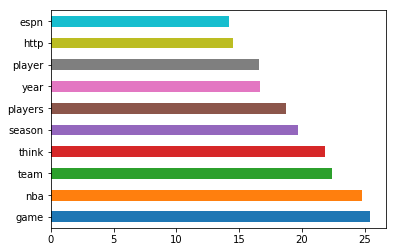

In [11]:
X_tv_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

## Predicting subreddit using Random Forests + Another Classifier

#### We want to predict a binary variable - class `0` for one of your subreddits and `1` for the other.

In [12]:
# 1 if the first target else 0
y_bin = [1 if i == str(subreddit[0].Target[0]) else 0 for i in full_data.Target]
# y_bin.count(0)
# subreddit[0]

#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [13]:
# train, split data
# put y_bin instead of y, since we want 1 or 0
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, stratify=y, random_state=42)

In [14]:
# transform our train and test data (X)
X_tr_tv = tv.fit_transform(X_train)
X_te_tv = tv.transform(X_test)

In [15]:
# randomforest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr_tv, y_train);

In [16]:
# random forest score on the test set
rf.score(X_te_tv, y_test)

0.8867313915857605

In [17]:
predictions = rf.predict(X_te_tv)

In [18]:
confusion_matrix(y_test, predictions)

array([[156,  21],
       [ 14, 118]])

#### Thought experiment: What is the baseline accuracy for this model?

In [19]:
# baseline accuracy, the percentage of higher(majority)
ba = full_data['Target'].value_counts(normalize=True)[0] * 100 # show percentage
ba

57.351509250243424

In [20]:
# a confusion matrix 

def make_pretty_conmat(y_test, predictions):
    conmat = confusion_matrix(y_test, predictions)
    conmat_df = pd.DataFrame(conmat)
    conmat_df = conmat_df.add_prefix('Predicted: ')
    print(f"accuracy score: {accuracy_score(y_test, predictions)}")
    return conmat_df

make_pretty_conmat(y_test, predictions)

accuracy score: 0.8867313915857605


,Predicted: 0,Predicted: 1
0,156,21
1,14,118


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [21]:
# using GridSearchCV with Pipeline to optimize TfidfVectorizer with Randomforest
pipeline = Pipeline([
    ('tv', tv),
    ('rf', rf)
])

params = {
    'tv__stop_words': [None, custom_stopwords, ENGLISH_STOP_WORDS],
    'tv__max_features': [3000, 4000],
    'tv__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [50, 100, 150]
}

gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [22]:
gs.best_score_

0.9220055710306406

In [23]:
# GridSearchCV score on test set
gsscore = gs.score(X_test, y_test)
gsscore

0.9255663430420712

In [24]:
# best parameters of GridSearchCV using pipeline
gs.best_params_

{'rf__n_estimators': 100,
 'tv__max_features': 4000,
 'tv__ngram_range': (1, 1),
 'tv__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
            'been',
       

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

In [25]:
# LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_tr_tv, y_train)
lrscore = lr.score(X_te_tv, y_test)

# MultinomialNB
nb = MultinomialNB()
nb.fit(X_tr_tv, y_train)
nbscore = nb.score(X_te_tv, y_test)

# GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_tr_tv, y_train)
gbscore = gb.score(X_te_tv, y_test)

# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr_tv, y_train)
rfscore = rf.score(X_te_tv, y_test)

# create a table
table = pd.DataFrame(index=['Logistic Regression', 'Multinomial NB', 'Gradient Boosting', 'Random Forest', 'GridSearchCV'])
table.index.name = 'Model'
table['Test Data Score'] = [lrscore, nbscore, gbscore, rfscore, gsscore]

table.sort_values('Test Data Score', ascending=False)

,Test Data Score
Model,
Logistic Regression,0.932039
GridSearchCV,0.925566
Multinomial NB,0.912621
Gradient Boosting,0.889968
Random Forest,0.886731


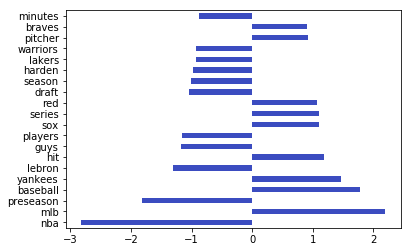

In [26]:
### Analyze the coefs 

coefs = pd.DataFrame(lr.coef_,columns=tv.get_feature_names()).T
coefs['ABS'] = coefs[0].abs()
coefs.sort_values(by='ABS', ascending=False).head(20)[0].plot(kind='barh', cmap='coolwarm');

# Executive Summary
---
Put your executive summary in a Markdown cell below.

Nike is the one of the biggest sportswear company in the world. The challenge is that Nike is sharing their customers' interests such as Adidas and Under Armor. One of the methods that attract customers to buy Nike products is putting ads where people see most. So, where should Nike put ads?

Finding places where you put ads is not easy. Where are people that are interested in buying Nike products? Which website/subreddit should you pick to get more attention from people who are interested in purchasing new sports products? I am here for you to find the best places online. Putting ads in the right places will increase the number of buyers and will help to beat your competitors. 

My model analyzes words in an article then find out which subreddit (website) it came from. It will also show the frequency of the words, so the user can grasp what people are talking about most. By understanding what people are talking about in a specific thread, Nike will be able to put a related advertisement. 

For example, using this tool, Nike will find a subreddit which people talk a lot about LeBron James where the company can put new LeBron James basketball shoes.

I love working with Nike that repects diversity. I want to contribute on Nike's success in near future. In order to increase the number of people who 'Just Buy It', I recommend using this model to analyze customers' needs and their thoughts. What are your buyers talking now? Which subreddit they talk most? Let's figure things out.
Just Do It with my model.
